In [ ]:
import iris
import numpy as np
from iris import quickplot as qplt
from matplotlib import pyplot as plt
%matplotlib inline

In [934]:
!conda install --update-deps iris -y

Fetching package metadata .......
Solving package specifications: ..........

Package plan for installation in environment /opt/conda:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-env-2.6.0            |                0          502 B
    conda-4.3.18               |           py35_0         514 KB
    ------------------------------------------------------------
                                           Total:         514 KB

The following packages will be UPDATED:

    conda:     4.2.13-py35_0 conda-forge --> 4.3.18-py35_0

The following packages will be SUPERCEDED by a higher-priority channel:

    conda-env: 2.6.0-0       conda-forge --> 2.6.0-0      

Pruning fetched packages from the cache ...
Fetching packages ...
conda-env-2.6. 100% |################################| Time: 0:00:00 743.48 kB/s
conda-4.3.18-p 100% |################################| Time: 0:00:00  23.68 MB

In [ ]:
from mogreps_utils import list_files, unrotate, get_uk_from_global, get_info, get_ground_level

In [877]:
g_files = list_files('mogreps-g', 'prods_op_mogreps-g_20160207', 2000)
uk_files = list_files('mogreps-uk', 'prods_op_mogreps-uk_20160207', 2000)

In [878]:
len(g_files)

2000

In [879]:
variable = 'relative_humidity'

In [880]:
def blitz(cube):
    cube.var_name = cube.standard_name
    for c in cube.aux_coords:
        c.var_name = c.standard_name

In [881]:
def get_uk_global_pairs(param, uk_files, g_files, blat, blon, uk_path='../data/mogreps-uk/', g_path='../data/mogreps-gg/'):
    '''Return two CubeLists of matching UK and global cubes, each containing one timestep, for the given param.'''
    uks = iris.cube.CubeList([])
    gs = iris.cube.CubeList([])
    
    stash = iris.load(uk_path + uk_files[0], param)[0].attributes['STASH'].__str__()
    stash_const = iris.AttributeConstraint(STASH=stash)
    
    for fname in uk_files:
        info = get_info(fname)
        uk_fname = fname
        g_fname = 'prods_op_mogreps-g_{}_{:02d}_{:02d}_{:03d}.nc'.format(info[0], info[1]-3, info[2], info[3]+3)

        if g_fname in g_files:
            try:
                g_cube = iris.load(g_path + g_fname, stash_const)[0]
                uk_cube = iris.load(uk_path + uk_fname, stash_const)[0]
                
                time_constraint = iris.Constraint(time=uk_cube.coord('time').points[-1])
                g_cube = g_cube.extract(time_constraint)
                uk_cube = uk_cube.extract(time_constraint)
                
                uk_cube, uk_h = get_ground_level(uk_cube)
                if uk_h: uk_cube.remove_coord(uk_h)
                g_cube, g_h = get_ground_level(g_cube)
                if g_h: g_cube.remove_coord(g_h)
                    
                uk_unrotate = unrotate(uk_cube, g_cube)
                uk_unrotate = uk_unrotate.intersection(latitude=blat, longitude=blon)
                g_cube = g_cube.intersection(latitude=blat, longitude=blon)

                blitz(uk_unrotate)
                blitz(g_cube)
                
                uks.append(uk_unrotate)
                gs.append(g_cube)
            except (IndexError, AttributeError):
                pass
    return (uks, gs)

In [ ]:
%%time 
uks, gs = get_uk_global_pairs(variable, uk_files, g_files, blat=(57, 58), blon=(0,1))

 /opt/conda/lib/python3.5/site-packages/iris/fileformats/cf.py:1140: IrisDeprecation:NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.


CPU times: user 5min, sys: 4.05 s, total: 5min 4s
Wall time: 53min 23s


In [885]:
scheme=iris.analysis.Nearest()

In [886]:
%%time
uks_regrid = iris.cube.CubeList([uks[i].regrid(grid=gs[i], scheme=scheme) for i in range(len(uks))])

CPU times: user 5.78 s, sys: 316 ms, total: 6.1 s
Wall time: 3min 45s


In [887]:
print(uks_regrid[0])

relative_humidity / (%)             (latitude: 3; longitude: 2)
     Dimension coordinates:
          latitude                           x             -
          longitude                          -             x
     Scalar coordinates:
          forecast_period: 3.0 hours
          forecast_reference_time: 2016-02-07 03:00:00
          time: 2016-02-07 06:00:00
     Attributes:
          Conventions: CF-1.5
          STASH: m01s16i256
          source: Data from Met Office Unified Model
          um_version: 10.1


In [937]:
for c in uks_regrid + gs:
    try:
        c.coord('realization')
    except iris.exceptions.CoordinateNotFoundError:
        c.add_aux_coord(iris.coords.DimCoord(0, standard_name='realization', var_name='realization'))

In [977]:
from jade_utils.iris_tools.padded_orthogonal_merge import _flatten, _get_missing_points_in_coord_space

In [1192]:
def _make_masked_cube_for_point(template_cube, coord_names, point):
        c = template_cube.copy()
        constraints = {}
        for name in coord_names:
            constraints[name] = c.coord(name).points[0]
        constraint = iris.Constraint(**constraints)
        new_cube = c.extract(constraint)
        for i, coord_name in enumerate(coord_names):
            new_cube.coord(coord_name).points = (point[i],)
        lazy_data = new_cube.lazy_data()
        data = np.ma.masked_all(lazy_data.shape, dtype=lazy_data.dtype)
        new_cube.data = data
        return new_cube

In [1195]:
def padded_orthogonal_merge(cube_list, orthogonal_coords):
    # TODO: should we always use the first cube as a template?
    # TODO: check that all cubes have the required orthogonal_coords as scalar coords and filter those that don't?
    cubes = _flatten(cube_list)
    missing_cubes = []
    for point in _get_missing_points_in_coord_space(cubes, orthogonal_coords):
        missing_cubes.append(_make_masked_cube_for_point(cubes[0], orthogonal_coords, point))
    cubes += missing_cubes
    return cubes.merge_cube()

In [1200]:
uks_regrid_c = padded_orthogonal_merge(uks_regrid, ['time', 'realization'])
gs_c = padded_orthogonal_merge(gs, ['time', 'realization'])

uks_regrid_c.remove_coord('forecast_period')
gs_c.remove_coord('forecast_period')

uks_regrid_c.remove_coord('forecast_reference_time')
gs_c.remove_coord('forecast_reference_time')

In [1201]:
diff = uks_regrid_c - gs_c

In [1202]:
diff.collapsed(['latitude', 'longitude'], iris.analysis.RMS).data

 /opt/conda/lib/python3.5/site-packages/iris/cube.py:3254: UserWarning:Collapsing spatial coordinate 'latitude' without weighting
 /opt/conda/lib/python3.5/site-packages/iris/coords.py:992: UserWarning:Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
 /opt/conda/lib/python3.5/site-packages/iris/coords.py:992: UserWarning:Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.


masked_array(data = [23.34545815927943 5.3587448001685365 21.021008836399837 13.614005502912555
 21.39837902739364 15.929123615775811 8.275056646331794 15.724102385615954
 17.301026583221393 10.64581294844754 5.86079843821073 13.530925227049332
 25.145721140318617 2.907873650395881 22.105865077696762 21.61476154545006
 30.639622359509154 9.655255477372586 14.325458107858191 19.315769680065387
 20.487610585424548 11.750775683616238 10.76537176165629 21.205099622496473
 22.188820383247055 17.64508312061276 22.789228998220484 22.293672028178758
 24.69406558264556 13.815940370938684 7.379412521784283 24.108154740668144
 16.410584744812315 17.824301645973865 13.987066198218029
 14.527900599650774 21.51483257739491 8.042044464355234 23.51656109709354
 9.96987650374868 24.96022878167052 16.428348212769293 10.24822139040071
 18.273315585848124 20.891772204227514 14.491017332586878 18.96824374667653
 6.016470449247355 11.503283045867095 11.273932876330248 20.881922504884457
 22.52394559130349 2

In [1203]:
diff.collapsed(diff.coords(), iris.analysis.RMS).data

 /opt/conda/lib/python3.5/site-packages/iris/cube.py:3254: UserWarning:Collapsing spatial coordinate 'latitude' without weighting
 /opt/conda/lib/python3.5/site-packages/iris/coords.py:992: UserWarning:Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
 /opt/conda/lib/python3.5/site-packages/iris/coords.py:992: UserWarning:Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
 /opt/conda/lib/python3.5/site-packages/iris/coords.py:992: UserWarning:Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'realization'.
 /opt/conda/lib/python3.5/site-packages/iris/coords.py:992: UserWarning:Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.


array(16.98051959260731)

In [1204]:
i = -1

0


 /opt/conda/lib/python3.5/site-packages/iris/coords.py:802: UserWarning:Coordinate 'longitude' is not bounded, guessing contiguous bounds.
 /opt/conda/lib/python3.5/site-packages/iris/coords.py:802: UserWarning:Coordinate 'latitude' is not bounded, guessing contiguous bounds.


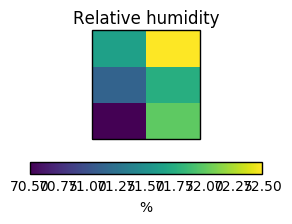

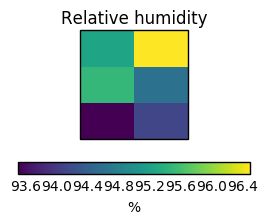

In [1205]:
i += 1
print(i)
plt.figure(figsize=(3,2))
qplt.pcolormesh(gs[i], cmap='viridis')
plt.figure(figsize=(3,2))
qplt.pcolormesh(uks_regrid[i], cmap='viridis')

In [1206]:
import GPy

In [1213]:
samples = gs_c.shape[0]
n = int(samples / 2)
dims = gs[0].shape[0] * gs[0].shape[1]

X = gs_c.data.reshape(samples, dims, 1)[:n, 0]
Y = uks_regrid_c.data.reshape(samples, dims, 1)[:n, 0]

X_test = gs_c.data.reshape(samples, dims, 1)[n:, 0]
Y_test = uks_regrid_c.data.reshape(samples, dims, 1)[n:, 0]

In [1214]:
k = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X, Y, k)

In [1220]:
m.optimize_restarts(3)

 /opt/conda/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/3, f = 869.4396889541815
Optimization restart 2/3, f = 869.4396890842143
Optimization restart 3/3, f = 869.439688955477


In [1216]:
m.objective_function()

869.4396894423119

In [1217]:
m.gradient

array([ -8.11228565e-08,  -3.14828138e-05,  -4.92982256e-05])

 /opt/conda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


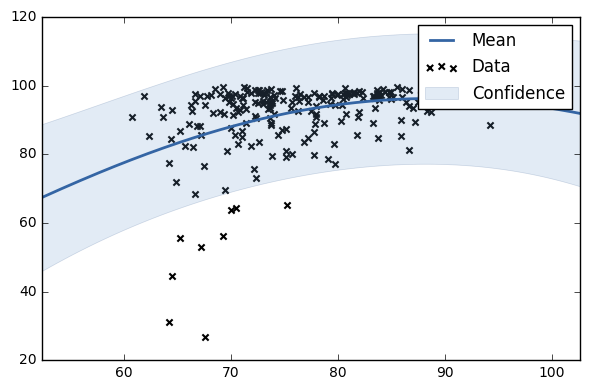

In [1218]:
m.plot()

In [1254]:
m.predict(X_test)[0] - Y_test

TypeError: 'NoneType' object is not subscriptable

In [1222]:
np.mean(np.abs(m.predict(X_test)[0] - Y_test))

5.7402255447616257

In [1262]:
X = [gs_c.data.reshape(samples, dims)[:n, :] for _ in range(dims)]
Y = [uks_regrid_c.data.reshape(samples, dims, 1)[:n, i] for i in range(dims)]

tst = gs_c.data.reshape(samples, dims)[n:]
X_test = np.ma.MaskedArray([np.hstack((tst, np.ones((tst.shape[0], 1))*i)) for i in range(dims)]).reshape(dims*(samples - n), -1)
Y_test = np.ma.MaskedArray([uks_regrid_c.data.reshape(samples, dims, 1)[n:, i] for i in range(dims)]).squeeze(axis=-1)

In [1263]:
k = GPy.kern.RBF(input_dim=6, variance=1., lengthscale=1.)
icm = GPy.util.multioutput.ICM(input_dim=6, num_outputs=6, kernel=k)
m = GPy.models.GPCoregionalizedRegression(X, Y, kernel=icm)

In [1278]:
K1 = GPy.kern.Bias(6)
K2 = GPy.kern.RBF(6)
K3 = GPy.kern.RBF(6)
K4 = GPy.kern.RBF(6)
lcm = GPy.util.multioutput.LCM(input_dim=6,num_outputs=6,kernels_list=[K1,K2,K3,K4])

m = GPy.models.GPCoregionalizedRegression(X, Y, kernel=lcm)
# m['.*ICM.*var'].unconstrain()
# m['.*ICM0.*var'].constrain_fixed(1.)
# m['.*ICM0.*W'].constrain_fixed(0)
# m['.*ICM1.*var'].constrain_fixed(1.)
# m['.*ICM1.*W'].constrain_fixed(0)
# m['.*ICM2.*var'].constrain_fixed(1.)
# m['.*ICM2.*W'].constrain_fixed(0.)
# m['.*ICM3.*var'].constrain_fixed(1.)
# m['.*ICM3.*W'].constrain_fixed(0.)

In [1279]:
m.optimize_restarts(2, verbose=True)

Optimization restart 1/2, f = 4686.7128933439


LinAlgError: not pd: non-positive diagonal elements

In [1280]:
m.objective_function()

4686.7128933439

In [1281]:
m.gradient

array([  2.86911126e-04,   6.61708857e-03,  -1.67652439e-03,
         6.18362243e-03,  -4.62322547e-03,  -5.39409782e-03,
        -2.95260463e-04,  -4.36728310e+01,  -8.76092889e+00,
        -7.80432345e+01,  -4.57607064e+01,  -4.13048613e+01,
        -1.40137910e+01,  -6.67487719e-05,  -1.56518683e-03,
        -2.28019107e-03,  -1.82689432e-03,   9.63527415e-04,
         1.57371762e-03,  -1.76810179e-03,   3.25339698e-04,
        -1.23918920e+00,  -9.62720781e-04,  -3.25597973e+00,
        -2.15824215e+00,  -4.89983075e-02,  -6.92473617e-03,
        -5.60773071e-04,  -0.00000000e+00,   3.24938604e-03,
        -2.73540954e-04,   2.15879232e-03,  -1.06570176e-03,
         1.75390780e-04,  -1.74724587e-03,  -3.63004214e-03,
        -2.15282346e-03,  -1.46698538e-03,  -3.93722929e-01,
         1.50357384e-03,   2.41069521e-03,   1.65310207e-03,
        -0.00000000e+00,   2.51790037e-05,   1.92654739e-03,
         2.91923833e-03,  -8.70089487e-04,  -2.08541439e-04,
        -3.15647017e-03,

In [1282]:
(m.predict(np.array(X_test), include_likelihood=False)[0].reshape(-1, samples - n) - Y_test)

masked_array(data =
 [[-89.67085771928515 -97.5423673941998 -94.74978997223428 -93.7770664155833
  -78.02706641085086 -96.27706593617557 -50.901474438414965
  -95.94227797379924 -86.8520980836926 -96.6550260252609 -97.15233029247993
  -96.15102673158675 -81.02798997681158 -94.61178711767708
  -93.51606496933228 -80.02622357388663 -74.15197770967121 -74.28014506691
  -84.76201975309984 -96.40206641089057 -96.02032379640833
  -97.27749553867915 -98.40003141134574 -90.78363757265609
  -92.26641216127625 -88.5415363850002 -97.02544659473627
  -94.27804737822787 -94.90208684871799 -97.03305057126579
  -68.29133735135767 -97.02682593636148 -97.27791552908269
  -98.21910634730811 -99.03303782471775 -85.5549908569631
  -89.15526026076665 -97.40274304426175 -92.27705777378745
  -97.52119415066294 -87.53948087919133 -85.04558546114741
  -83.7666734434246 -95.41352555566212 -92.22038091101288
  -92.93731015068269 -98.77388839670226 -99.1520672092395
  -94.30100295184275 -95.20056221188858 -97.152

In [1283]:
np.mean(np.abs(m.predict(np.array(X_test), include_likelihood=False)[0].reshape(-1, samples - n) - Y_test))

91.349018768983271

 /opt/conda/lib/python3.5/site-packages/GPy/likelihoods/gaussian.py:101: RuntimeWarning:invalid value encountered in sqrt


 /opt/conda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


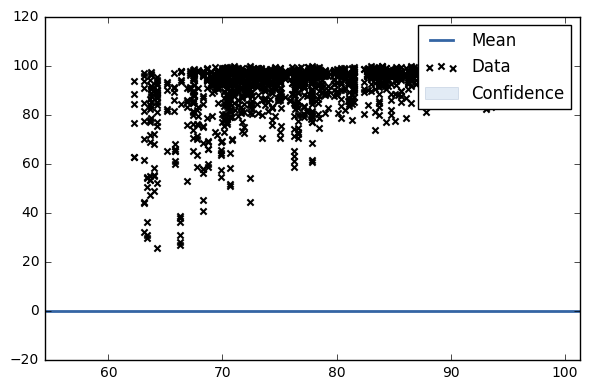

In [1284]:
m.plot(visible_dims=[2])

 /opt/conda/lib/python3.5/site-packages/iris/coords.py:802: UserWarning:Coordinate 'longitude' is not bounded, guessing contiguous bounds.
 /opt/conda/lib/python3.5/site-packages/iris/coords.py:802: UserWarning:Coordinate 'latitude' is not bounded, guessing contiguous bounds.


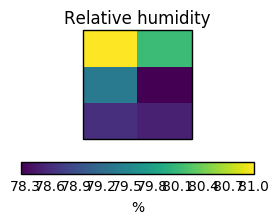

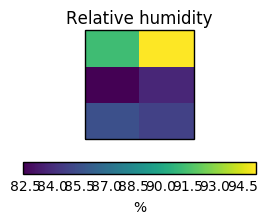

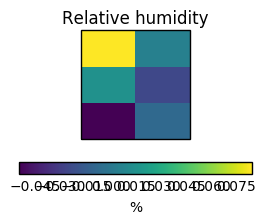

In [1285]:
i = 35
tst = gs_c.data.reshape(samples, dims)[n + i]
test = np.array([np.hstack((tst, np.ones((tst.shape[0]))*i)) for i in range(dims)]).reshape(dims, -1)
res = m.predict(test, include_likelihood=False)[0]

plt.figure(figsize=(3,2))
qplt.pcolormesh(gs[n + i], cmap='viridis')
plt.figure(figsize=(3,2))
qplt.pcolormesh(uks_regrid[n + i], cmap='viridis')

tmp = uks_regrid[n + i].copy()
tmp.data = res.reshape(3,2)
plt.figure(figsize=(3,2))
qplt.pcolormesh(tmp, cmap='viridis')